# Preprocess data, and obtain data from the first 20 PVs.

In [1]:
import scipy.io as scio
import numpy as np
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# load data
data = scio.loadmat('201803a_Origin.mat')
data = data['data']

In [3]:
def matlab2datetime(matlab_datenum):
    day = datetime.datetime.fromordinal(int(matlab_datenum))
    day = day.replace(year=day.year + 1900)
    dayfrac = datetime.timedelta(days=matlab_datenum %
                                 1) - datetime.timedelta(days=366)
    return day + dayfrac

In [4]:
pv_devices = list()
for idx in range(20):
    if idx == 2-1 or idx == 4-1:
        current_device = {'time': None,
                          'power': np.zeros((50,), dtype=np.float64)}
        pv_devices.append(current_device)
    else:
        current_device = {'time': list(), 'power': list()}
        for (tval, pval) in zip(data[:, 2*idx], data[:, 2*idx+1]):
            if tval == 0:
                break
            current_device['time'].append(matlab2datetime(tval))
            current_device['power'].append(pval)
        # current_device['power'] = np.array(current_device['power'])
        pv_devices.append(current_device)

In [5]:
(pv_devices[0]['time'][0] - datetime.datetime(2018, 3, 30)).total_seconds()

-1757999.999998

# Data analysis

In [6]:
def get_devices(date_day):
    pv_devices_ = list()
    for idx_device in range(len(pv_devices)):
        if idx_device == 2-1 or idx_device == 4-1:
            pv_devices_.append(pv_devices[idx_device])
        else:
            for idx_time_start in range(len(pv_devices[idx_device]['time'])):
                if (pv_devices[idx_device]['time'][idx_time_start] 
                    >= datetime.datetime(2018, 3, date_day)):
                    break
            for idx_time_end in range(idx_time_start, len(pv_devices[idx_device]['time'])):
                if not (pv_devices[idx_device]['time'][idx_time_end] 
                        < datetime.datetime(2018, 3, date_day+1)):
                    break
            pv_devices_.append(
                {'time': 
                 pv_devices[idx_device]['time'][idx_time_start:idx_time_end],
                 'power': 
                 np.array(pv_devices[idx_device]['power']
                          [idx_time_start:idx_time_end])}
            )
    return pv_devices_

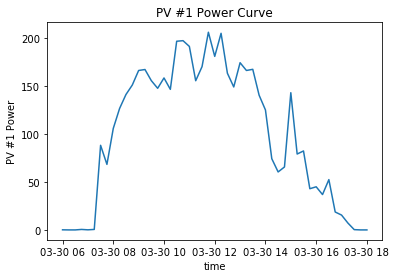

In [7]:
pv_devices_30 = get_devices(30)
fig = plt.figure()
plt.plot(pv_devices_30[0]['time'], pv_devices_30[0]['power'])
plt.xlabel('time')
plt.ylabel('PV #1 Power')
plt.title('PV #1 Power Curve')
plt.show()

## Data from 2018-3-30

In [8]:
from GMM_Distribution import GMM_distribution
import math
import functional
import operator

In [9]:
def calculate_matrices(pv_devices):
    # 建立GMM模型
    GMMs_30 = list()
    for pv_device in pv_devices:
        GMMs_30.append(GMM_distribution(
            pv_device['power'], 3, 'EM', 'marginal')['GMM'])

    KL_matrix_30 = np.zeros((len(GMMs_30), len(GMMs_30)), dtype=np.float64)
    # 计算KL距离矩阵的上三角部分
    for i in range(len(GMMs_30)):
        for j in range(i+1, len(GMMs_30)):
            KL_matrix_30[i, j] = functional.func_MonteCaro_JS(
                GMMs_30[i], GMMs_30[j], 1000)
    # 补全
    KL_matrix_30 = KL_matrix_30.T + KL_matrix_30
    np.fill_diagonal(KL_matrix_30, 0)
    return KL_matrix_30


def plot_matrix(matrix, mode):
    N = matrix.shape[0]
    fig2 = plt.figure(figsize=(10, 6))
    plt.imshow(matrix)
    plt.colorbar()
    plt.xticks(range(0, N), range(1, N+1))
    plt.yticks(range(0, N), range(1, N+1))
    plt.xlabel('PV number')
    plt.ylabel('PV number')
    if mode == 'KL':
        plt.title('KL divergence between different PVs')
    else:
        plt.title('Correlations of KL divergence')
    plt.show()

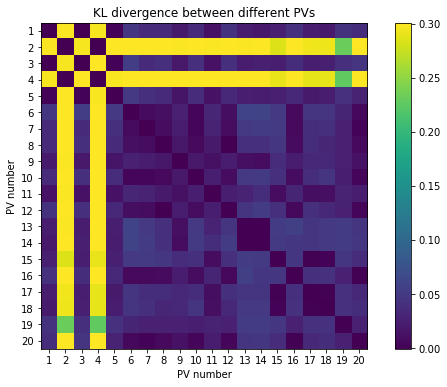

In [10]:
KL_30 = calculate_matrices(pv_devices_30)
plot_matrix(KL_30, 'KL')

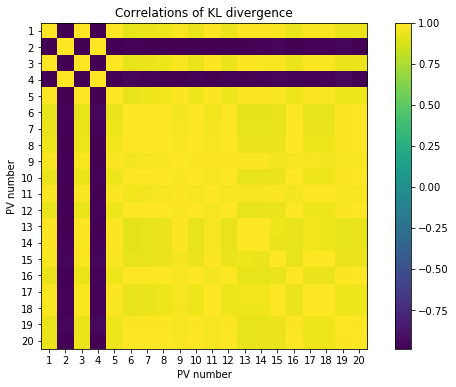

In [11]:
corr_KL_30 = np.corrcoef(KL_30.T)
plot_matrix(corr_KL_30, 'corrKL')

## Data from 2018-3-23

In [12]:
pv_devices_23 = get_devices(23)
KL_23 = calculate_matrices(pv_devices_23)
corr_KL_23 = np.corrcoef(KL_23.T)

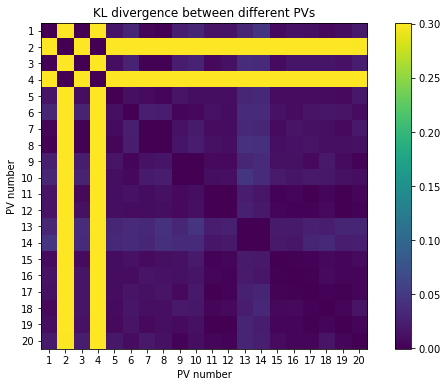

In [13]:
plot_matrix(KL_23, 'KL')

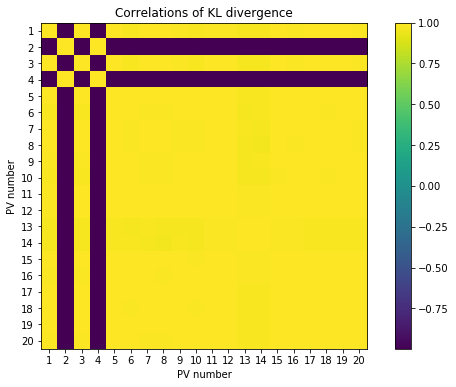

In [14]:
plot_matrix(corr_KL_23, 'corrKL')

## Modified data from 2018-3-30

In [15]:
import copy
pv_devices_30_fixed = copy.deepcopy(pv_devices_30)
pv_devices_30_fixed[1]['power'] = 0.35*pv_devices_30_fixed[0]['power'] + \
    25*np.random.rand(*pv_devices_30_fixed[0]['power'].shape)
pv_devices_30_fixed[1]['time'] = pv_devices_30_fixed[0]['time']
pv_devices_30_fixed[3]['power'] = 0.35*pv_devices_30_fixed[0]['power'] + \
    30*np.random.rand(*pv_devices_30_fixed[0]['power'].shape)
pv_devices_30_fixed[3]['time'] = pv_devices_30_fixed[0]['time']

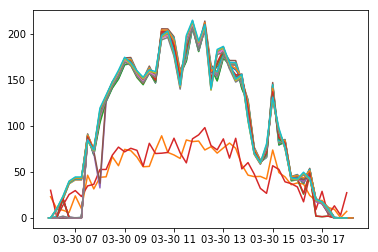

In [16]:
fig = plt.figure()
for pv_device in pv_devices_30_fixed:
    plt.plot(pv_device['time'], pv_device['power'])
plt.show()

In [17]:
KL_30_fixed = calculate_matrices(pv_devices_30_fixed)
corr_KL_30_fixed = np.corrcoef(KL_30_fixed.T)

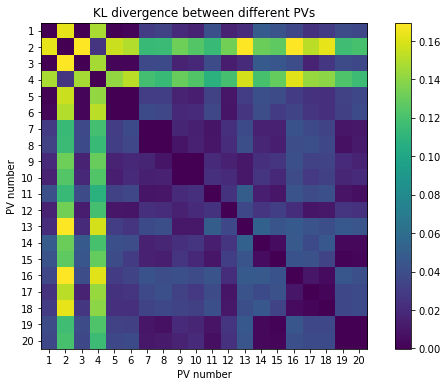

In [18]:
plot_matrix(KL_30_fixed, 'KL')

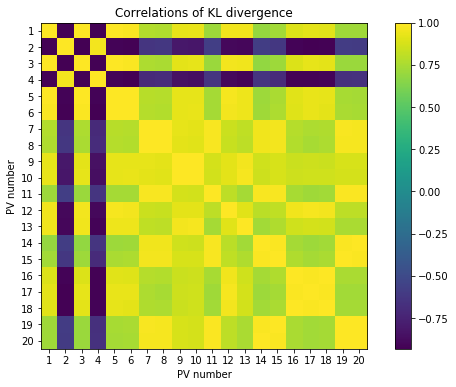

In [19]:
plot_matrix(corr_KL_30_fixed, 'corrKL')